<a href="https://colab.research.google.com/github/abolfazl328/DnsServer_GUI/blob/main/GTZAN_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install audiomentations

ابتدا کتاب خانه های مورد نظر را به پروژه اضافه میکنیم.

In [ ]:
import kagglehub
import os
import librosa
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split  # For data splitting
import audiomentations
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

در این بخش به علت استفاده از جی پی یو در صورت وجود جی پی یو آن را شناسایی کرده و به تنسور میگوییم که از جی پی یو استفاده کند.

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True) # Prevents memo
      print("GPU is available and enabled for training.")
  except RuntimeError as e:
    print(e)

GPU is available and enabled for training.


در کد زیر دادگان از کگل دانلود کرده و به مسیر جنریز اورجینال میرویم.

In [ ]:
# Download latest version
path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")+"/Data/genres_original"
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1/Data/genres_original


In [ ]:
list_of_musics = os.listdir(path)
list_of_musics

['pop',
 'rock',
 'jazz',
 'disco',
 'metal',
 'hiphop',
 'blues',
 'reggae',
 'classical',
 'country']

تابع زیر اعداد به فرمت ۵ رقمی تبدیل میکند به صورتی که به سمت چپ اعداد صفر اضافه میکند به تعدادی که آن عدد ۵ رقمی شود.
این تابع برای ساختن اسم فایل ها استفاده میشود.

In [ ]:
def format_with_zeros(number):
  return "{:05d}".format(number)

تابع زیر با گرفتن مسیر یک فایل آن فایل را با کمک کتابخانه لیبروسا لود میکند و همچنین تابع زیر در صورت وجود خطا در آپلود یک فایل آن خطا را هندل کرده و آن فایل را اسکیپ میکند.

In [ ]:
  def loadaudio(audio_file):
    try:
      audio, sr = librosa.load(audio_file, sr=None) # Load with a maximum duration of 30 seconds
      return audio, sr
    except Exception as e:
      print(f"Error loading audio file {audio_file}: {e}")
      return None, None

در کد زیر زنجیره ای از تبدیل ها برای تبدیل فایل های صوتی و اسخت فایل های جدید است تا بتوان مشکل اورفیتیتنگ را با افزایش دادگان ورودی حل کرد.
در کد زیر در یک مرحله کشش زمانی رخ میدهد.
در مرحله بعد شیفت زمانی در دوره تناوب رخ میدهد.
در مرحله بعد نویز گاوسی اضافه میشود.
در مرحله بعد گین را تنظیم میکنیم و مین و ماکس را ست میکنیم. گین همان ولوم موزیک حساب میشود.
از لول بعدی برای نرمال سازی صوت یعنی عادی سازی صوت تبدیل شده استفاده میشود.
باید توجه داشت که گمان میشود در صورت تبدیل یک صوت به ۳ صوت دیگر هر ۳ صوت ساخته مشابه یکدیگر خواهند بود. اما باید در نظر گرفت که در هر مرحله از تبدیل احتمال وقوع آن مرحله ۵۰ درصد است پس در صورت تبدیل بک فایل صوتی به ۳ فایل صوتی جدید احتمال تشابه آنها بسیا کم است.

In [ ]:
augmenter = audiomentations.Compose([
    audiomentations.TimeStretch(min_rate=0.8, max_rate=1.2, p=0.5),
    audiomentations.PitchShift(min_semitones=-2, max_semitones=2, p=0.5),
    audiomentations.AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    audiomentations.Gain(min_gain_db=-3, max_gain_db=3, p=0.5),
    audiomentations.Normalize(p=0.5),
])

با فراخوانی تابع زیر تیدل صوت صورت میپذیرد.

In [ ]:
def process_audio(y, sr, augment=False):
    if augment:
        try:
            y = augmenter(samples=y, sample_rate=sr)
        except Exception as e:
            print(f"Augmentation error for {audio_file}: {e}")
    return y, sr

در کد زیر تمامی ۱۰۰۰ داده را خوانده و سپس بر روی هر کدام از آنها ۳ بار تبدیل انجام میدهیم. باید توجه داشت در مرحله زیر هم نرمال سازی صورت میگیرد و هم تبدیل صوت ها برای ساخت صوت های جدید. اما این را نیز باید در نظر گرفت که هم دادگان نرمال نشده از کد زیر بدست می آیند هم دادگان نرمال شده.
باید در نظر داشت بخاطر سنگینی بخش که مراحلی چون لود فایل تبدیل فایل استخراج ویژگی های فایل های صوتی ذخیره آن در متغیر های مربوطه و سپس نرمال سازی آنها و باز ذخیره آنها در متغیر مربوطه کد  زیر در بازه زمانی طولانی اجرا خواهد شد.
همچنین بعد از تلاش های بسیار متوجه شدم که یکی از فایل ها یعنی فایل شماره ۵۴ از دسته جز با مشکل خواندن همراه است برای همین این فایل اسکیپ میشود.

In [ ]:
normalized_x = []
normalized_y = []
unnormalized_x = []
unnormalized_y = []
n_augmentations_per_clip = 3
for j in range(100):
  k = 0
  for i in list_of_musics:
    audio_file = path+f"/{i}/{i}.{format_with_zeros(j)}.wav"
    audio, sr = loadaudio(audio_file)
    if audio is None:
      continue
    for i in range(n_augmentations_per_clip):
      audio_augmented, sr = process_audio(audio, sr, augment=True) # dummy process_audio call for augment
      mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)  # Adjust n_mels as needed
      log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max) # Convert to decibels
      unnormalized_x.append(log_mel_spectrogram)
      unnormalized_y.append(k)
      mean = np.mean(log_mel_spectrogram, axis=(0, 1), keepdims=True)  # Mean across time and channels
      std = np.std(log_mel_spectrogram, axis=(0, 1), keepdims=True)
      epsilon = 1e-7
      normalized_spectrogram = (log_mel_spectrogram - mean) / (std + epsilon)
      normalized_x.append(np.array(normalized_spectrogram))
      normalized_y.append(k)
    k+=1

<ipython-input-7-d60cec9024df>:3: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(audio_file, sr=None) # Load with a maximum duration of 30 seconds
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error loading audio file /root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1/Data/genres_original/jazz/jazz.00054.wav: 


در بخش زیر دادگان نرمال شده و نرمال نشده را به بخش های آموزش و تست تبدیل میشود.

In [ ]:
unnorm_x_train, unnorm_x_test, unnorm_y_train, unnorm_y_test = train_test_split(unnormalized_x, unnormalized_y, test_size=0.2, random_state=42) # 80% train, 20% test
norm_x_train, norm_x_test, norm_y_train, norm_y_test = train_test_split(normalized_x, unnormalized_y, test_size=0.2, random_state=42) # 80% train, 20% test

در بخش زیر لیبل ها را به یک بردار ۱۰ تایی تبدیل کرده به صورتی که گر لیبل برار با ۱ باشد به صورت زیر نمایش داده میشود:
[0,1,0,0,0,0,0,0,0,0]

In [ ]:
num_classes = 10
unnorm_y_train = tf.keras.utils.to_categorical(unnorm_y_train, num_classes=num_classes)
unnorm_y_test = tf.keras.utils.to_categorical(unnorm_y_test, num_classes=num_classes)
norm_y_train = tf.keras.utils.to_categorical(norm_y_train, num_classes=num_classes)
norm_y_test = tf.keras.utils.to_categorical(norm_y_test, num_classes=num_classes)

توابع جنریتور زیر اکس و وای را بازگردانده و یک بعد بعد دادگان ورودی یعنی اکس اضافه میکند.

In [ ]:
# def generator_train():
#     for x, y_ in zip(x_train, y_train):
#         yield np.expand_dims(x, axis=-1), y_  # Add channel dimension HERE

# def generator_test():
#     for x, y_ in zip(x_test, y_test):
#         yield np.expand_dims(x, axis=-1), y_
generator_unnorm_train = lambda: ((np.expand_dims(x, axis=-1), y_) for x, y_ in zip(unnorm_x_train, unnorm_y_train))
generator_norm_train = lambda: ((np.expand_dims(x, axis=-1), y_) for x, y_ in zip(norm_x_train, norm_y_train))
generator_unnorm_test = lambda: ((np.expand_dims(x, axis=-1), y_) for x, y_ in zip(unnorm_x_test, unnorm_y_test))
generator_norm_test = lambda: ((np.expand_dims(x, axis=-1), y_) for x, y_ in zip(norm_x_test, norm_y_test))

در بخش زیر با استفاده از تابع جنریتور مرتبط دیتاست تنسور را میسازیم به این صورت که ابتدا تابع سازنده صدا زده میشود سپس در مرحله بعد ابعاد داده های خروجی از تابع سازنده تنظیم میشود.
در مرحله بعد از پدینگ صفر استفاده میشود تا سایز تمامی دادگان درون هر بچ یکسان است اما سایز دادگان بچ ها میتواند باهم متفاوت باشد زیرا این پدینگ بر اساس بزرگترین سایز دادگان موجود در هر بچ اتفاق میافتد یعنی به اندازه بزرگترین در هر بچ به دادگان کوچکتر صفر اضافه میشود ولی ممکن است بزرگترین در هر بچ متفاوت باشد.

In [ ]:
unnorm_train_dataset = tf.data.Dataset.from_generator(
    # generator_train,
    generator_unnorm_train,
    output_signature=(
        tf.TensorSpec(shape=(128, None, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(num_classes,), dtype=tf.float32),
    ),
).padded_batch(
    batch_size=32,
    padded_shapes=([128, None, 1], [num_classes]),  # Pad time dimension to None
    padding_values=(0.0, 0.0), # Padding value for spectrograms and labels
    drop_remainder=False # Keep last batch even if it is not full
)

norm_train_dataset = tf.data.Dataset.from_generator(
    # generator_train,
    generator_norm_train,
    output_signature=(
        tf.TensorSpec(shape=(128, None, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(num_classes,), dtype=tf.float32),
    ),
).padded_batch(
    batch_size=32,
    padded_shapes=([128, None, 1], [num_classes]),  # Pad time dimension to None
    padding_values=(0.0, 0.0), # Padding value for spectrograms and labels
    drop_remainder=False # Keep last batch even if it is not full
)


unnorm_test_dataset = tf.data.Dataset.from_generator(
    generator_unnorm_test,
    output_signature=(
        tf.TensorSpec(shape=(128, None, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(num_classes,), dtype=tf.float32),
    ),
).padded_batch(
    batch_size=32,
    padded_shapes=([128, None, 1], [num_classes]),  # Pad time dimension to None
    padding_values=(0.0, 0.0), # Padding value for spectrograms and labels
    drop_remainder=False # Keep last batch even if it is not full
)

norm_test_dataset = tf.data.Dataset.from_generator(
    generator_norm_test,
    output_signature=(
        tf.TensorSpec(shape=(128, None, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(num_classes,), dtype=tf.float32),
    ),
).padded_batch(
    batch_size=32,
    padded_shapes=([128, None, 1], [num_classes]),  # Pad time dimension to None
    padding_values=(0.0, 0.0), # Padding value for spectrograms and labels
    drop_remainder=False # Keep last batch even if it is not full
)

حال از مدل سی ان ان استفاده میکنیم.
زیرا این مدل وابسته به داده وروردی نیست.
این مدل از ۸ لایه تشکیل شده است.
در ابندا ۳ لایه اول به ترتیب زیر هستند:
لایه اول یک لایه کانولوشنی است که از کرنل ۳ در ۳ و تابع فعال ساز رلو استفاده میکند. همچنین از منظم ساز ال ۲ استفاده میکند. باید توجه داشت که در لایه اول باید ابعاد ورودی را مشخص کرد.
در لایه بعد از یک لایه نرمال ساز استفاده میکنیم به ایت صورت که داده های حروجی از لایه قبل در هر بچ را نرمال میکند.
در لایه سوم نیز از یک لایه ماکزیمم پولین برای کاهش اعاد استفاده میکنیم.
این ۳ لایه یکبار دیگر تتا لایه ۶ تکرار میشوند.
سپس در لایه ۷ از یک گلوبال اورج پولین استفاده میکنیم تا محدودیت در ابعاد از بین برود.
سپس از یک لایه دسته بندی با تابع فعال ساز سافت مکس با تعداد ۱۰ نورون استفاده میکنیم.
در لایه های اول و ۴ هم نیز به ترتیتب از ۳۲ و ۶۴ نورون استفاده میکنیم.
سپس مدل را با بهینه ساز ادام کامپایل میکنیم.
همچنین از تابع خطای کتگوریکال کراس انتروپی استفاده کردیم .
خطا را نیز در هنکام ترین نمایش میدهیم.

In [ ]:
model= tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), input_shape=(128, None, 1)),
    tf.keras.layers.BatchNormalization(),  # Add Batch Normalization
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),  # Add Batch Normalization
    tf.keras.layers.MaxPooling2D((2, 2)),

    # tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # More Conv layers
    # tf.keras.layers.BatchNormalization(),  # Add Batch Normalization
    # tf.keras.layers.MaxPooling2D((2, 2)),

    # tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),  # Even more Conv layers
    # tf.keras.layers.BatchNormalization(),  # Add Batch Normalization
    # tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.GlobalAveragePooling2D(),

    # tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Larger Dense Layer
    # tf.keras.layers.Dropout(0.5),  # Dropout for regularization

    # tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Another Dense Layer
    # tf.keras.layers.Dropout(0.5),  # Dropout for regularization

    tf.keras.layers.Dense(num_classes, activation='softmax')  # Output layer
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


از توقف زودهنگام برای جلوگیری از بیش برازش استفاده میکنیم به نوعی که اگر بعد از تعداد ۵ دور آموزش تغییری در حطا رخ نداد اموزش را متوقف کرده و وزن های قبلی را به عنوان بعترین وزن ها انتخاب کند.

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,         # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore the weights from the epoch with the best validation loss
)

برای حل مشکل بیش برازش از أموزش ضریب اموزش نیز استفاده کردیم به این صورت که اگر بعد از ۳ دور بهبودی رخ نداد ضریب اموزش را کاهش میدهیم.
بعد از هر ۳ دور در صورتی که هیچ گونه پیشرفتی خاصل نشود ضریب اموزش نصف میشود.

In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.5,          # Reduce learning rate by this factor (e.g., 0.5)
    patience=3,         # Number of epochs with no improvement before reducing LR
    min_lr=1e-5         # Minimum learning rate
)


در ابتدا دادگان نرمال سازی نشده را اموزش میدهیم به تعداد ۵۰ دور.

In [ ]:
unnormalized_data_train_history = model.fit(
    unnorm_train_dataset,
    epochs=50,
    validation_data=unnorm_test_dataset,
    callbacks=[early_stopping, reduce_lr]  # Add the callback here
    )  # Adjust epochs and batch size as needed

Epoch 1/50
     75/Unknown 103s 1s/step - accuracy: 0.3689 - loss: 2.2765

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


75/75 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.3698 - loss: 2.2731 - val_accuracy: 0.1983 - val_loss: 3.0619 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 0.5534 - loss: 1.6671 - val_accuracy: 0.2500 - val_loss: 2.1419 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 0.6088 - loss: 1.4727 - val_accuracy: 0.3233 - val_loss: 2.3759 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.6347 - loss: 1.3533 - val_accuracy: 0.3767 - val_loss: 1.9600 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.6656 - loss: 1.2543 - val_accuracy: 0.3600 - val_loss: 1.9176 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.6838 - loss: 1.1817 - val_accuracy: 0.3617 - val_loss: 2.2068 - learning_rate: 0.0010
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.6962 - loss: 1.1159 - val_ac

از این تابع برای اندازه گیری اب وان اسکور - خطا - دقت- ماتریس درهم رختگی استفاده میشود.

In [ ]:
def caluclate_measures(norm):
  y_pred_probs = []
  y_true = []
  if not norm:
    for x, y in unnorm_test_dataset:  # Iterate over the TensorFlow Dataset
      y_pred_batch_probs = model.predict(x)  # Predict probabilities for the current batch
      y_pred_probs.extend(y_pred_batch_probs)  # Append the batch predictions
      y_true.extend(y.numpy())  # Append the true labels
    loss = model.evaluate(unnorm_test_dataset, verbose=0)[0] # Loss from evaluate function
    # y_pred = np.argmax(y_pred_probs, axis=1)  # Predicted labels
    # y_true = np.argmax(y_true, axis=1)  # True labels (convert one-hot to class labels)
  else:
    for x, y in norm_test_dataset:  # Iterate over the TensorFlow Dataset
      y_pred_batch_probs = model.predict(x)  # Predict probabilities for the current batch
      y_pred_probs.extend(y_pred_batch_probs)  # Append the batch predictions
      y_true.extend(y.numpy())  # Append the true labels
    loss = model.evaluate(norm_test_dataset, verbose=0)[0] # Loss from evaluate function
  y_pred = np.argmax(y_pred_probs, axis=1)  # Predicted labels
  y_true = np.argmax(y_true, axis=1)  # True labels (convert one-hot to class labels)
  f1 = f1_score(y_true, y_pred, average='macro')
  precision = precision_score(y_true, y_pred, average='macro')
  recall = recall_score(y_true, y_pred, average='macro')
  cm = confusion_matrix(y_true, y_pred)
  accuracy = tf.keras.metrics.Accuracy()(y_true, y_pred).numpy()
  yield y_pred
  yield y_true
  yield accuracy
  yield loss
  yield f1
  yield precision
  yield recall
  yield cm

In [ ]:
unnorm_data_test_y_pred, unnorm_data_test_y_true, unnorm_data_test_accuracy, unnorm_data_test_loss, unnorm_data_test_f1, unnorm_data_test_precision, unnorm_data_test_recall, unnorm_data_test_cm = caluclate_measures(0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


چاپ نتایح بدست امده

In [ ]:
print(f"Test Loss: {unnorm_data_test_loss}")
print(f"Test Accuracy: {unnorm_data_test_accuracy}")
print(f"F1-score: {unnorm_data_test_f1}")
print(f"Precision: {unnorm_data_test_precision}")
print(f"Recall: {unnorm_data_test_recall}")
print("Confusion Matrix:")
print(unnorm_data_test_cm)

Test Loss: 0.7974700331687927
Test Accuracy: 0.7400000095367432
F1-score: 0.7250076485861414
Precision: 0.8012193550661199
Recall: 0.7408800618464297
Confusion Matrix:
[[51  5  2  0  0  0  1  1  0  0]
 [ 1 39  1  0  3  0 14  3  0  0]
 [ 0  0 61  0  0  0  3  1  2  0]
 [ 9  9  0 17  0  0 11 12  0  2]
 [ 0  8  0  0 45  1  2  0  0  0]
 [ 5  1  0  0  1 52  0  3  0  0]
 [ 0  0  0  0  0  0 52  0  0  0]
 [ 1  0  0  0  0  4  5 56  0  0]
 [ 0  0  4  0  0  0  0  0 53  0]
 [ 1 16  3  0  0  0 20  1  0 18]]


حال دادگان نرمال سازی شده را در ۵۰ دور اموزش میدهیم.

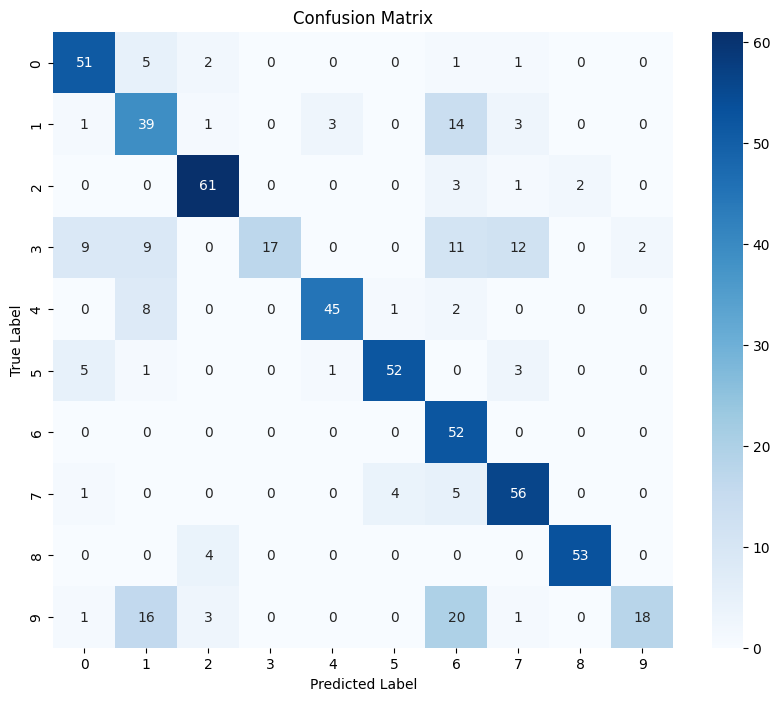

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(unnorm_data_test_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(unnorm_data_test_y_true), yticklabels=np.unique(unnorm_data_test_y_pred)) # set labels
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
normalized_data_train_history = model.fit(
    norm_train_dataset,
    epochs=50,
    validation_data=norm_test_dataset,
    callbacks=[early_stopping, reduce_lr]  # Add the callback here
    )  # Adjust epochs and batch size as needed

Epoch 1/50
     75/Unknown 9s 123ms/step - accuracy: 0.6460 - loss: 1.2051

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.6468 - loss: 1.2028 - val_accuracy: 0.0933 - val_loss: 16.3474 - learning_rate: 2.5000e-04
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 0.7792 - loss: 0.8100 - val_accuracy: 0.0933 - val_loss: 12.0909 - learning_rate: 2.5000e-04
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.8020 - loss: 0.7541 - val_accuracy: 0.1150 - val_loss: 7.7114 - learning_rate: 2.5000e-04
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 0.8163 - loss: 0.7258 - val_accuracy: 0.2183 - val_loss: 3.9719 - learning_rate: 2.5000e-04
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 0.8215 - loss: 0.7068 - val_accuracy: 0.4017 - val_loss: 1.9775 - learning_rate: 2.5000e-04
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.8270 - loss: 0.6920 - val_accuracy: 0.5800 - val_loss: 1.2035 - learning_rate: 2.5000e-04
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.

In [ ]:
norm_data_test_y_pred, norm_data_test_y_true, norm_data_test_accuracy, norm_data_test_loss, norm_data_test_f1, norm_data_test_precision, norm_data_test_recall, norm_data_test_cm = caluclate_measures(1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


In [ ]:
print(f"Test Loss: {norm_data_test_loss}")
print(f"Test Accuracy: {norm_data_test_accuracy}")
print(f"F1-score: {norm_data_test_f1}")
print(f"Precision: {norm_data_test_precision}")
print(f"Recall: {norm_data_test_recall}")
print("Confusion Matrix:")
print(norm_data_test_cm)

Test Loss: 0.6589935421943665
Test Accuracy: 0.8033333420753479
F1-score: 0.7981012931180658
Precision: 0.8304732696812964
Recall: 0.8045698389525512
Confusion Matrix:
[[52  1  2  0  0  0  3  2  0  0]
 [ 0 34  0  0  4  1 10  5  0  7]
 [ 0  0 66  0  0  0  0  1  0  0]
 [ 4 11  0 25  0  0  5 12  0  3]
 [ 0  1  0  0 54  0  1  0  0  0]
 [ 5  1  0  0  1 48  0  7  0  0]
 [ 0  0  0  0  0  0 50  2  0  0]
 [ 0  2  0  0  0  2  5 57  0  0]
 [ 0  0  8  0  0  0  0  0 49  0]
 [ 0  1  5  0  0  0  3  3  0 47]]


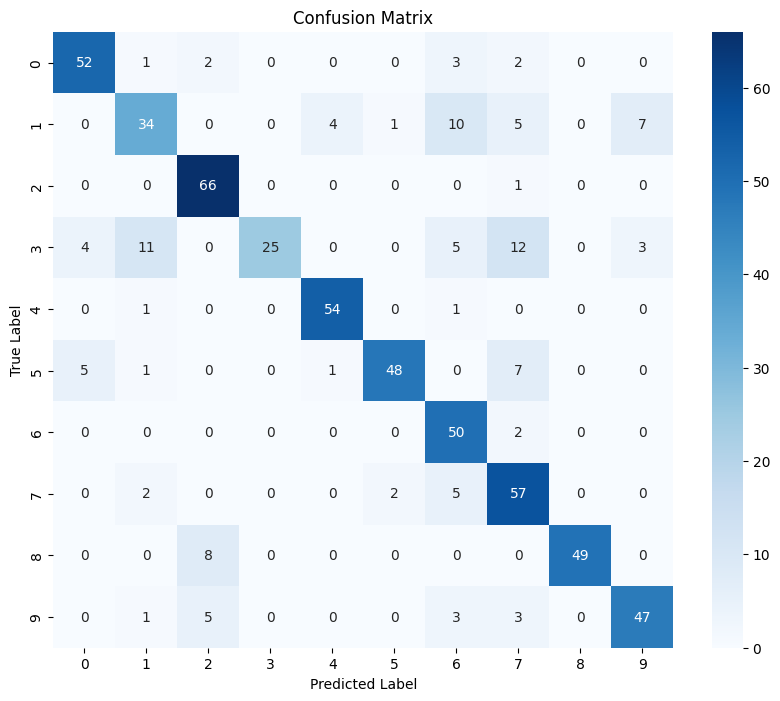

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(norm_data_test_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(norm_data_test_y_true), yticklabels=np.unique(norm_data_test_y_pred)) # set labels
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

همانطور که از نتایج اموزش دادگان نرمال سازی نشده مشخص است با وجود تمام تلاش های صورت گرفته مدل دچار بیش برازش شده است و این را از نتایج اموزش و تست میتوان نتیجه گرفت.
زیرا احرین دقت بدست امده از ترین 0.85 است در حالی که در هنگام تست دقت در حدود مقدار 0.74 است.
اما از نتایج بدست امده از اموزش دادگان نرمال سازی شده میتوان نتیجه گرفت که دقت در حدود 0.89 است که بهبود دقت در هنگام اموزش نسبت اموزش دادگان نرمال سازی نشده را نشان میدهد.
همچنین دقت در هنگام تست در حدود 0.80 است که خود نشان دهنده این است که مشکل بیش برازش با استفاده از نرمال سازی تا حد زیادی حل شده و دقت بدست امده خوب و قابل قبول است.